In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip -u "/content/drive/My Drive/dub2_data.zip" -d "/content/drive/My Drive/dub2_projekt"

In [1]:
from scipy import ndimage
from matplotlib.pyplot import imshow
import torch

In [2]:
#!git clone https://TOKEN@github.com/mperic7/du2_projekt duboko_projekt

#data

In [3]:
from drive.MyDrive.duboko_projekt import faces_dataset, pickle_images2

In [2]:
#%run -i 'drive/MyDrive/duboko_projekt/pickle_images2.py'
from torchvision import transforms
# from drive.MyDrive.duboko_projekt.faces_dataset import FacesDataset
# dataset_x = FacesDataset("/content/drive/MyDrive/duboko_projekt/dub2_data/subset_1000/pickled/celeba_hq_256", transform=transforms.ToTensor())
# dataset_y = FacesDataset("/content/drive/MyDrive/duboko_projekt/dub2_data/subset_1000/pickled/avg_blurred_images", transform=transforms.ToTensor())

from faces_dataset import FacesDataset
dataset_x = FacesDataset("dub2_data\\pickled\\celeba_hq_256", transform=transforms.ToTensor())
dataset_y = FacesDataset("dub2_data\\pickled\\avg_blurred_images", transform=transforms.ToTensor())

In [3]:
from torch.utils.data import DataLoader, SubsetRandomSampler
# K = 2000
# subsample_train_indices = torch.randperm(len(dataset_x))[:K]
# dataloader_x = DataLoader(dataset_x, batch_size=128, sampler=SubsetRandomSampler(subsample_train_indices))
# dataloader_y = DataLoader(dataset_y, batch_size=128, sampler=SubsetRandomSampler(subsample_train_indices))
dataloader_x = DataLoader(dataset_x, batch_size=128, shuffle=True)
dataloader_y = DataLoader(dataset_y, batch_size=128, shuffle=True)

In [5]:
from drive.MyDrive.duboko_projekt.networks import Generator, Discriminator

ModuleNotFoundError: No module named 'drive'

In [4]:
from networks import Generator, Discriminator

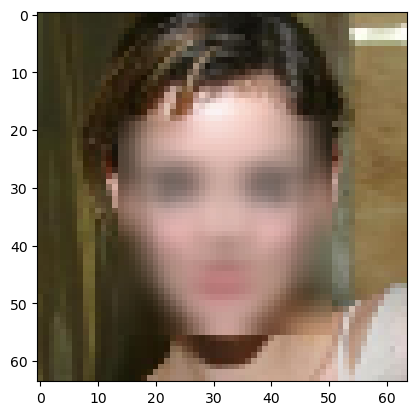

In [9]:
from PIL import Image
import numpy as np
def show_img(x):
    imshow(x.permute(1,2,0))
s = next(iter(dataloader_y))#.shape
show_img(s[0])

#training

In [5]:
gen_x = Generator(3, num_features=32)
gen_y = Generator(3, num_features=32)

disc_x = Discriminator(3, features=[64, 128, 256, 512])
disc_y = Discriminator(3, features=[64, 128, 256, 512])

In [12]:
pytorch_total_params = sum(p.numel() for p in gen_x.parameters() if p.requires_grad)
pytorch_total_params

1965059

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
gen_x = gen_x.to(device)
disc_x = disc_x.to(device)

gen_y = gen_y.to(device)
disc_y = disc_y.to(device)

In [8]:
gen_x.load_state_dict(torch.load('models\\gen_x_ckpt.pt'))
gen_y.load_state_dict(torch.load('models\\gen_y_ckpt.pt'))

<All keys matched successfully>

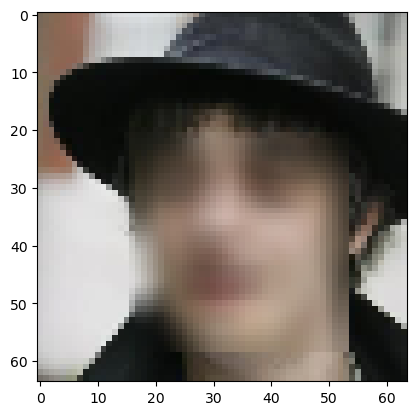

In [31]:
blurred = next(iter(dataloader_y))[0]
show_img(blurred)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


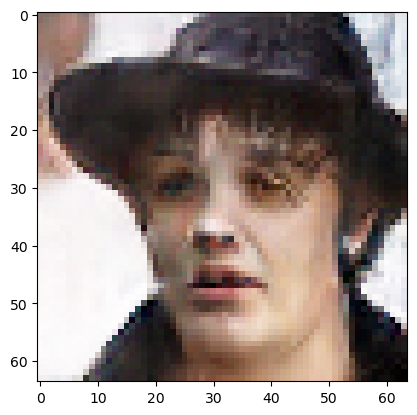

In [33]:
blurred = blurred.to(device)
fake = gen_x(blurred)
show_img(fake.detach().cpu())

In [15]:
from tqdm import tqdm

In [111]:
import torch
from matplotlib import pyplot as plt
import os
bce_loss = torch.nn.BCELoss()
l1_loss = torch.nn.L1Loss()

lambda_identity = 0.01
lambda_cycle = 0.1
epochs = 200
opt_disc = torch.optim.Adam(
        list(disc_x.parameters()) + list(disc_y.parameters()),
        lr=0.001,
        betas=(0.5, 0.999),
    )
opt_gen = torch.optim.Adam(
        list(gen_x.parameters()) + list(gen_y.parameters()),
        lr=0.001,
        betas=(0.5, 0.999),
    )

fig = plt.figure()
step = 0
for e in range(epochs):
    pbar = tqdm(dataloader_x)
    for i, (x,y) in enumerate(zip(pbar, dataloader_y)):

        y = y[:x.shape[0]]

        opt_disc.zero_grad()
        opt_gen.zero_grad()

        x = x.to(device)
        y = y.to(device)


        fake_x = gen_x(y)
        disc_x_real = disc_x(x)
        dics_x_fake = disc_x(fake_x)

        fake_y = gen_y(x)
        disc_y_real = disc_y(y)
        dics_y_fake = disc_y(fake_y)

        identity_x = gen_x(x)
        identity_y = gen_y(y)

        cycle_y = gen_y(fake_x)


        #identity
        identity_loss = lambda_identity * (l1_loss(identity_x,x) + l1_loss(identity_y,y))
        #cycle
        cycle_loss = lambda_cycle * l1_loss(cycle_y,y)

        if step % 6 < 3: #update discriminator
            disc_x_gan_loss = bce_loss(disc_x_real, torch.ones_like(disc_x_real)) + bce_loss(dics_x_fake, torch.zeros_like(dics_x_fake))
            disc_y_gan_loss = bce_loss(disc_y_real, torch.ones_like(disc_y_real)) + bce_loss(dics_y_fake, torch.zeros_like(dics_y_fake))
            gan_loss = disc_x_gan_loss + disc_y_gan_loss

            disc_loss = gan_loss + identity_loss + cycle_loss
            disc_loss.backward()
            opt_disc.step()

            #print(disc_loss)
        else: #update generator
            gen_x_gan_loss = bce_loss(disc_x_real, torch.zeros_like(disc_x_real)) + bce_loss(dics_x_fake, torch.ones_like(dics_x_fake))
            gen_y_gan_loss = bce_loss(disc_y_real, torch.zeros_like(disc_y_real)) + bce_loss(dics_y_fake, torch.ones_like(dics_y_fake))
            gan_loss = gen_x_gan_loss + gen_y_gan_loss
            gen_loss = gan_loss + identity_loss + cycle_loss
            gen_loss.backward()
            opt_gen.step()

            #print(gen_loss)

        pbar.set_postfix(CYCLE_LOSS=cycle_loss.item())
        # if step % 10 == 0:
        #     # print(gan_loss, identity_loss, cycle_loss)
        #     show_img(fake_x[0].cpu().detach())
        #     plt.show()
        #     torch.save(gen_x.state_dict(), os.path.join("models", "gen_x_ckpt.pt"))
        #     torch.save(gen_x.state_dict(), os.path.join("models", "gen_x_ckpt.pt"))
        step += 1

    print(gan_loss, identity_loss, cycle_loss)
    show_img(fake_x[0].cpu().detach())
    plt.show()
    torch.save(gen_x.state_dict(), os.path.join("models", "gen_x_ckpt.pt"))
    torch.save(gen_y.state_dict(), os.path.join("models", "gen_y_ckpt.pt"))


  0%|          | 0/234 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 12.00 GiB total capacity; 17.58 GiB already allocated; 0 bytes free; 18.65 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

<Figure size 640x480 with 0 Axes>

In [19]:
SAVE_PATH = "/content/drive/MyDrive/duboko_projekt/dub2_data/subset_1000/"
torch.save(gen_x.state_dict(), SAVE_PATH + "gen_x.pth")
torch.save(gen_y.state_dict(), SAVE_PATH + "gen_y.pth")

torch.save(disc_x.state_dict(), SAVE_PATH + "disc_x.pth")
torch.save(disc_y.state_dict(), SAVE_PATH + "disc_y.pth")


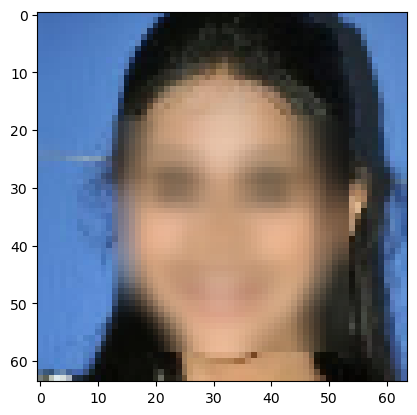

In [36]:
gen_x.load_state_dict(torch.load('models\\gen_x_ckpt.pt'))
gen_y.load_state_dict(torch.load('models\\gen_y_ckpt.pt'))
blurred = next(iter(dataloader_y))[0]
show_img(blurred)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


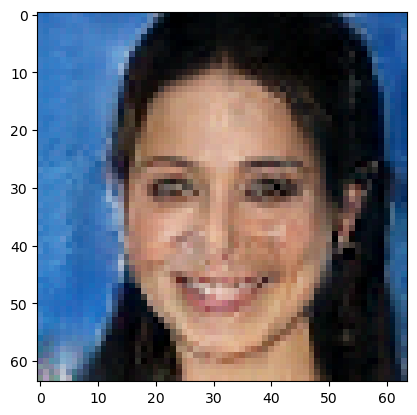

In [37]:
blurred = blurred.to(device)
fake = gen_x(blurred)
show_img(fake.detach().cpu())